### Note on how to request data directly from WRDS
#### Before this you need to install Pandas (you should have this already), Psycopg2 and wrds

#### go to your anaconda prompt

#### 1.    pip install psycopg2
#### 2.    pip install wrds
#### 3.    go through codes below.

# Adv Portfolio Mgmt: Group Assigment 1

### by Tong, Shea, Leon

In [1]:
import wrds

import pandas as pd
from scipy.stats import norm, skew, kurtosis
import matplotlib.pyplot as plt
%matplotlib inline
import random

## WRDS Direct Connect

In [2]:
db= wrds.Connection()

Enter your WRDS username [Owner]:tongmin
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [3]:
stock = db.get_table(library= 'crsp', table='stocknames',obs = 10)

In [4]:
db.raw_sql("SELECT * from crsp.dsf limit 5")

,cusip,permno,permco,issuno,hexcd,hsiccd,date,bidlo,askhi,prc,vol,ret,bid,ask,shrout,cfacpr,cfacshr,openprc,numtrd,retx
0,48526010,25523.0,21034.0,0.0,1.0,4911.0,1962-10-10,27.750,28.000,28.000,1400.0,0.009009,None,None,4700.0,1.0,1.0,None,None,0.009009
1,48526010,25523.0,21034.0,0.0,1.0,4911.0,1962-10-11,28.250,28.500,28.500,600.0,0.017857,None,None,4700.0,1.0,1.0,None,None,0.017857
2,48526010,25523.0,21034.0,0.0,1.0,4911.0,1962-10-12,28.250,28.625,28.250,1800.0,-0.008772,None,None,4700.0,1.0,1.0,None,None,-0.008772
3,48526010,25523.0,21034.0,0.0,1.0,4911.0,1962-10-15,28.500,28.500,28.500,200.0,0.008850,None,None,4700.0,1.0,1.0,None,None,0.008850
4,48526010,25523.0,21034.0,0.0,1.0,4911.0,1962-10-16,28.625,28.625,28.625,800.0,0.004386,None,None,4700.0,1.0,1.0,None,None,0.004386


## Pulling Data: Daily Monthly CRSP.DSF, CRSP.DSI, CRSP.MSF, CRSP.MSI then JOINs

In [5]:
dsf = db.raw_sql("SELECT date, permno, ret " 
           "FROM crsp.dsf "
           "WHERE (permno IN (83443, 90215, 57665, 22592, 90319, 55976, 12490, 85914, 89301, 84788) and date >= '2008-01-04') "
                         )

In [6]:
dsi = db.raw_sql("SELECT date, vwretd " 
           "FROM crsp.dsi "
           "WHERE (date >= '2008-01-04') "
                         )

In [7]:
dsf.set_index('date',inplace=True)
dsi.set_index('date',inplace=True)

In [8]:
ddf = dsf.join(dsi, how='inner')

In [9]:
ddf.head()

,permno,ret,vwretd
date,,,
2008-01-04,12490.0,-0.035939,-0.025649
2008-01-04,22592.0,-0.011366,-0.025649
2008-01-04,55976.0,-0.014230,-0.025649
2008-01-04,57665.0,-0.015468,-0.025649
2008-01-04,83443.0,-0.021505,-0.025649


In [10]:
msf = db.raw_sql("SELECT date, permno, ret " 
           "FROM crsp.msf "
           "WHERE (permno IN (83443, 90215, 57665, 22592, 90319, 55976, 12490, 85914, 89301, 84788) and date >= '2008-01-04') "
                         )

In [11]:
msi = db.raw_sql("SELECT date, vwretd " 
           "FROM crsp.msi "
           "WHERE (date >= '2008-01-04') "
                         )

In [12]:
msf.set_index('date',inplace=True)
msi.set_index('date',inplace=True)

In [13]:
mdf = msf.join(msi, how='inner')

In [14]:
mdf.head()

,permno,ret,vwretd
date,,,
2008-01-31,12490.0,-0.009158,-0.062147
2008-01-31,22592.0,-0.055384,-0.062147
2008-01-31,55976.0,0.067536,-0.062147
2008-01-31,57665.0,-0.045299,-0.062147
2008-01-31,83443.0,-0.039274,-0.062147


## Data Preparation

In [15]:
def compname(permno):
    if permno == 83443:
        return 'BRK.A'
    elif permno == 90215:
        return 'CRM'
    elif permno == 57665:
        return 'NKE'
    elif permno == 57665:
        return 'NKE'
    elif permno == 22592:
        return 'MMM'
    elif permno == 90319:
        return 'GOOGL'
    elif permno == 55976:
        return 'WMT'
    elif permno == 12490:
        return 'IBM'
    elif permno == 85914:
        return 'BBY'
    elif permno == 89301:
        return 'GME'
    elif permno == 84788:
        return 'AMZN'

In [16]:
comps = ['BRK.A', 'CRM', 'NKE', 'MMM', 'GOOGL', 'WMT', 'IBM', 'BBY', 'GME', 'AMZN']

In [17]:
#ddf.to_csv('Daily.csv')

In [18]:
#mdf.to_csv('Monthly.csv')

In [19]:
ddf['ticker'] = ddf['permno'].apply(lambda x: compname(x))

In [20]:
mdf['ticker'] = mdf['permno'].apply(lambda x: compname(x))

## Daily Data: Mean, Std, Skew, Kurtosis, VaR, Expected Shortfall

### * Everything is annualized except for VaR and ES in daily term. 
### Ex. VaR means how bad things can get in one day at 5% chance

In [21]:
meanddf = ddf.groupby('ticker').mean()

In [22]:
# mean of daily return

meanddf['ret'] *252

ticker
AMZN     0.324672
BBY      0.151266
BRK.A    0.102356
CRM      0.278031
GME     -0.002754
GOOGL    0.154746
IBM      0.086557
MMM      0.154987
NKE      0.192916
WMT      0.119117
Name: ret, dtype: float64

In [23]:
# std of daily return

stdddf = ddf.groupby('ticker').std()
stdddf['ret'] * (252**0.5)

ticker
AMZN     0.385751
BBY      0.427133
BRK.A    0.231622
CRM      0.419880
GME      0.426772
GOOGL    0.292849
IBM      0.220882
MMM      0.219362
NKE      0.284362
WMT      0.195355
Name: ret, dtype: float64

In [24]:
# VaR


mu = meanddf['ret'] 
std = stdddf['ret'] 
VaR = norm.ppf(0.05, mu, std)
VaR

array([-0.03868158, -0.04365761, -0.02359353, -0.04240301, -0.04423133,
       -0.02972975, -0.02254343, -0.02211439, -0.02869892, -0.01976926])

In [25]:
# Skewness

ddf.groupby('ticker').skew().drop(['permno', 'vwretd'], axis =1)['ret']

ticker
AMZN     1.033602
BBY      0.012250
BRK.A    1.197762
CRM      0.622292
GME     -0.372895
GOOGL    1.066669
IBM      0.089743
MMM      0.041821
NKE      0.544661
WMT      0.405433
Name: ret, dtype: float64

In [26]:
# Kurtosis

kurts = []

for comp in comps:
    kurt = kurtosis(ddf[ddf['ticker'] == comp]['ret'])
    kurts.append(kurt)
    print(comp, kurt)

BRK.A 18.86832247023187
CRM 7.797578374518162
NKE 8.367080457561253
MMM 5.996302698058887
GOOGL 15.295831261394799
WMT 12.254070951970457
IBM 6.611902572660467
BBY 13.306393774441926
GME 6.490673790569964
AMZN 12.086555015759508


In [27]:
len(ddf)*0.05/10

125.8

In [28]:
# expected shortfall in one-day
eslist = []
for comp in comps:
    esddf = ddf[ddf['ticker'] == comp].sort_values(['ret']).iloc[:126,:]
    es = esddf['ret'].mean()
    eslist.append(es)
    print(comp, es)

BRK.A -0.03226786105346585
CRM -0.058362670301918
NKE -0.03963483924726172
MMM -0.0337551035105236
GOOGL -0.041651292083164065
WMT -0.028123430331193265
IBM -0.033631619834710684
BBY -0.06096222198435238
GME -0.06544991898986084
AMZN -0.05183968134224414


In [29]:
# tracking error
trlist = []
for comp in comps:
    trl = ddf[ddf['ticker'] == comp]['ret'] - ddf['vwretd']
    tr = trl.std()
    trlist.append(tr)
    print(comp, tr)

BRK.A 0.011170310524414716
CRM 0.020978357657300623
NKE 0.013749480821711424
MMM 0.008828788077556582
GOOGL 0.014100072098148899
WMT 0.012519830411308028
IBM 0.01050249410523624
BBY 0.023227089513239662
GME 0.02331389983440478
AMZN 0.019862389457803723


In [30]:
# 10 Portfolio

dport =ddf.groupby('date').sum() * 0.1
dportmean = dport['ret'].mean() * 252
dportstd =  dport['ret'].std() * (252**0.5)
dportskew = dport['ret'].skew()
dportkurtosis = kurtosis(dport['ret'])
dportVaR = norm.ppf(0.05, dport['ret'].mean() , dport['ret'].std())
dportES = dport.sort_values(['ret']).iloc[:1510,:]['ret'].mean()
dportTE = (dport['ret'] - ddf['vwretd']).std()

dportrow =[dportmean, dportstd, dportskew, dportkurtosis, dportVaR, dportES, dportTE]

In [31]:
#rcomps = random.shuffle(comps)
#comps[0:5]

In [32]:
# summary of the results

resultddf = meanddf * 252
resultddf['std']= stdddf['ret'] * (252**0.5)
resultddf['skew']=ddf.groupby('ticker').skew().drop(['permno', 'vwretd'], axis =1)['ret']
resultddf['kurtosis'] = kurts
resultddf['VaR'] = VaR
resultddf['ES']= eslist
resultddf['tracking_er'] = trlist 
resultddf.drop(['permno','vwretd'], axis =1, inplace=True)
resultddf.loc['10port'] = dportrow

In [33]:
# add in  5 portfolio of 5 companies each

five1 = ['NKE', 'GOOGL', 'GME', 'IBM', 'CRM']
five2 = ['IBM', 'MMM', 'AMZN', 'BRK.A', 'GOOGL']
five3 = ['CRM', 'BBY', 'IBM', 'AMZN', 'WMT']
five4 = ['AMZN', 'NKE', 'GME', 'BBY', 'IBM']
five5 = ['AMZN', 'GME', 'BBY', 'MMM', 'CRM']

fivecomps = [five1, five2, five3, five4, five5]
ews = ['five1', 'five2', 'five3', 'five4', 'five5']

#completely randomly generated
#rcomps = random.shuffle(comps)
#comps[0:5]

for fives, ew in zip(fivecomps, ews):
    dfport = ddf[ddf['ticker'].isin(fives)].groupby('date').sum() * 0.2

    dfportmean = dfport['ret'].mean() * 252
    dfportstd =  dfport['ret'].std() * (252**0.5)
    dfportskew = dfport['ret'].skew()
    dfportkurtosis = kurtosis(dfport['ret'])
    dfportVaR = norm.ppf(0.05, dfport['ret'].mean() , dfport['ret'].std())
    dfportES = dfport.sort_values(['ret']).iloc[:1510,:]['ret'].mean()
    dfportTE = (dfport['ret'] - ddf['vwretd']).std()
    dfportrow = [dfportmean, dfportstd, dfportskew, dfportkurtosis, dfportVaR, dfportES, dfportTE]
    resultddf.loc[ew] = dfportrow


In [34]:
resultddf

,ret,std,skew,kurtosis,VaR,ES,tracking_er
ticker,,,,,,,
AMZN,0.324672,0.385751,1.033602,18.868322,-0.038682,-0.032268,0.011170
BBY,0.151266,0.427133,0.012250,7.797578,-0.043658,-0.058363,0.020978
BRK.A,0.102356,0.231622,1.197762,8.367080,-0.023594,-0.039635,0.013749
CRM,0.278031,0.419880,0.622292,5.996303,-0.042403,-0.033755,0.008829
GME,-0.002754,0.426772,-0.372895,15.295831,-0.044231,-0.041651,0.014100
GOOGL,0.154746,0.292849,1.066669,12.254071,-0.029730,-0.028123,0.012520
IBM,0.086557,0.220882,0.089743,6.611903,-0.022543,-0.033632,0.010502
MMM,0.154987,0.219362,0.041821,13.306394,-0.022114,-0.060962,0.023227
NKE,0.192916,0.284362,0.544661,6.490674,-0.028699,-0.065450,0.023314


In [35]:
# VaR = 'how bad can things get?'

# ES = 'if things do get bad, what is our expected loss?'

## Monthly Data: Mean, Std, Skew, Kurtosis, VaR, Expected Shortfall

### * Everything is annualized except for VaR and ES in monthly term. 
### Ex. VaR means how bad things can get in one month at 5% chance

In [36]:
meanmdf = mdf.groupby('ticker').mean()

In [37]:
# mean of monthly return

meanmdf['ret'] * 12

ticker
AMZN     0.307203
BBY      0.140361
BRK.A    0.088707
CRM      0.249765
GME     -0.021700
GOOGL    0.149637
IBM      0.076283
MMM      0.146783
NKE      0.177201
WMT      0.111467
Name: ret, dtype: float64

In [38]:
# std of daily return

stdmdf = mdf.groupby('ticker').std()
stdmdf['ret'] * (12**0.5)

ticker
AMZN     0.321883
BBY      0.420322
BRK.A    0.172211
CRM      0.348181
GME      0.387863
GOOGL    0.278951
IBM      0.184471
MMM      0.187661
NKE      0.231004
WMT      0.166726
Name: ret, dtype: float64

In [39]:
# VaR


mmu = meanmdf['ret'] 
mstd = stdmdf['ret'] 
mVaR = norm.ppf(0.05, mmu, mstd)
mVaR

array([-0.12723904, -0.18788424, -0.07437826, -0.14451246, -0.18597663,
       -0.11998401, -0.08123516, -0.07687491, -0.09492064, -0.06987749])

In [40]:
# Skewness

mdf.groupby('ticker').skew().drop(['permno', 'vwretd'], axis =1)['ret']

ticker
AMZN    -0.078265
BBY      0.274629
BRK.A    0.051800
CRM     -0.191756
GME      0.029012
GOOGL    0.327111
IBM     -0.530709
MMM     -0.295731
NKE     -0.177937
WMT     -0.032113
Name: ret, dtype: float64

In [41]:
# Kurtosis

mkurts = []

for comp in comps:
    mkurt = kurtosis(mdf[mdf['ticker'] == comp]['ret'])
    mkurts.append(mkurt)
    print(comp, mkurt)

BRK.A 1.0024403753794342
CRM 0.9263238477825242
NKE 0.1510564707059947
MMM 0.998915135976119
GOOGL 1.1201548581591734
WMT 1.038945611817386
IBM 1.5726442013393784
BBY 1.7211698880833888
GME -0.22074292069767454
AMZN 0.4009984246125611


In [42]:
len(mdf)*0.05/10

6.0

In [43]:
# expected shortfall in one-day
meslist = []
for comp in comps:
    esddf = mdf[mdf['ticker'] == comp].sort_values(['ret']).iloc[:7,:]
    es = esddf['ret'].mean()
    meslist.append(es)
    print(comp, es)

BRK.A -0.10007746411221377
CRM -0.178664775831359
NKE -0.12878682677234926
MMM -0.11288594986711234
GOOGL -0.14587211183139273
WMT -0.08872238227299271
IBM -0.11346591264009488
BBY -0.23219612027917583
GME -0.2177521863154003
AMZN -0.16586720304829758


In [44]:
# tracking error
mtrlist = []
for comp in comps:
    mtrl = mdf[mdf['ticker'] == comp]['ret'] - mdf['vwretd']
    mtr = mtrl.std()
    mtrlist.append(mtr)
    print(comp, mtr)

BRK.A 0.04665715515394824
CRM 0.08040251702645686
NKE 0.057724622208031706
MMM 0.03808604579160201
GOOGL 0.0667057849283687
WMT 0.056533648857307994
IBM 0.045490611145383046
BBY 0.10560041232160686
GME 0.10214857820261966
AMZN 0.08119063631549518


In [45]:
# 10 Portfolio

mport =mdf.groupby('date').sum() * 0.1
mportmean = mport['ret'].mean() * 12
mportstd =  mport['ret'].std() * (12**0.5)
mportskew = mport['ret'].skew()
mportkurtosis = kurtosis(mport['ret'])
mportVaR = norm.ppf(0.05, mport['ret'].mean() , mport['ret'].std())
mportES = mport.sort_values(['ret']).iloc[:1510,:]['ret'].mean()
mportTE = (mport['ret'] - ddf['vwretd']).std()

mportrow =[mportmean, mportstd, mportskew, mportkurtosis, mportVaR, mportES, mportTE]

In [46]:
# summary of the results

resultmdf = meanmdf * 12
resultmdf['std']= stdmdf['ret'] * (12**0.5)
resultmdf['skew']=mdf.groupby('ticker').skew().drop(['permno', 'vwretd'], axis =1)['ret']
resultmdf['kurtosis'] = mkurts
resultmdf['VaR'] = mVaR
resultmdf['ES']= meslist
resultmdf['tracking_er'] = mtrlist 
resultmdf.drop(['permno','vwretd'], axis =1, inplace=True)
resultmdf.loc['10port'] = mportrow

resultmdf

,ret,std,skew,kurtosis,VaR,ES,tracking_er
ticker,,,,,,,
AMZN,0.307203,0.321883,-0.078265,1.002440,-0.127239,-0.100077,0.046657
BBY,0.140361,0.420322,0.274629,0.926324,-0.187884,-0.178665,0.080403
BRK.A,0.088707,0.172211,0.051800,0.151056,-0.074378,-0.128787,0.057725
CRM,0.249765,0.348181,-0.191756,0.998915,-0.144512,-0.112886,0.038086
GME,-0.021700,0.387863,0.029012,1.120155,-0.185977,-0.145872,0.066706
GOOGL,0.149637,0.278951,0.327111,1.038946,-0.119984,-0.088722,0.056534
IBM,0.076283,0.184471,-0.530709,1.572644,-0.081235,-0.113466,0.045491
MMM,0.146783,0.187661,-0.295731,1.721170,-0.076875,-0.232196,0.105600
NKE,0.177201,0.231004,-0.177937,-0.220743,-0.094921,-0.217752,0.102149


In [47]:
# add in  5 portfolio of 5 companies each

five1 = ['NKE', 'GOOGL', 'GME', 'IBM', 'CRM']
five2 = ['IBM', 'MMM', 'AMZN', 'BRK.A', 'GOOGL']
five3 = ['CRM', 'BBY', 'IBM', 'AMZN', 'WMT']
five4 = ['AMZN', 'NKE', 'GME', 'BBY', 'IBM']
five5 = ['AMZN', 'GME', 'BBY', 'MMM', 'CRM']

fivecomps = [five1, five2, five3, five4, five5]
ews = ['five1', 'five2', 'five3', 'five4', 'five5']

#completely randomly generated
#rcomps = random.shuffle(comps)
#comps[0:5]

for fives, ew in zip(fivecomps, ews):
    mfport = mdf[mdf['ticker'].isin(fives)].groupby('date').sum() * 0.2

    mfportmean = mfport['ret'].mean() * 12
    mfportstd =  mfport['ret'].std() * (12**0.5)
    mfportskew = mfport['ret'].skew()
    mfportkurtosis = kurtosis(mfport['ret'])
    mfportVaR = norm.ppf(0.05, mfport['ret'].mean() , mfport['ret'].std())
    mfportES = mfport.sort_values(['ret']).iloc[:1510,:]['ret'].mean()
    mfportTE = (mfport['ret'] - ddf['vwretd']).std()
    mfportrow = [mfportmean, mfportstd, mfportskew, mfportkurtosis, mfportVaR, mfportES, mfportTE]
    resultmdf.loc[ew] = mfportrow


In [48]:
resultmdf

,ret,std,skew,kurtosis,VaR,ES,tracking_er
ticker,,,,,,,
AMZN,0.307203,0.321883,-0.078265,1.002440,-0.127239,-0.100077,0.046657
BBY,0.140361,0.420322,0.274629,0.926324,-0.187884,-0.178665,0.080403
BRK.A,0.088707,0.172211,0.051800,0.151056,-0.074378,-0.128787,0.057725
CRM,0.249765,0.348181,-0.191756,0.998915,-0.144512,-0.112886,0.038086
GME,-0.021700,0.387863,0.029012,1.120155,-0.185977,-0.145872,0.066706
GOOGL,0.149637,0.278951,0.327111,1.038946,-0.119984,-0.088722,0.056534
IBM,0.076283,0.184471,-0.530709,1.572644,-0.081235,-0.113466,0.045491
MMM,0.146783,0.187661,-0.295731,1.721170,-0.076875,-0.232196,0.105600
NKE,0.177201,0.231004,-0.177937,-0.220743,-0.094921,-0.217752,0.102149


## Graphs Daily

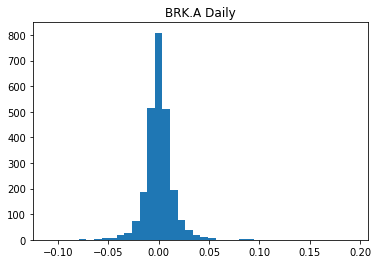

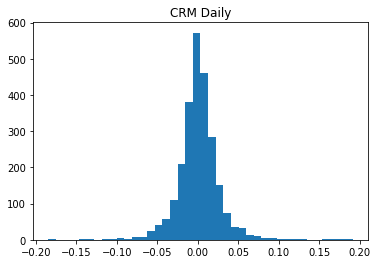

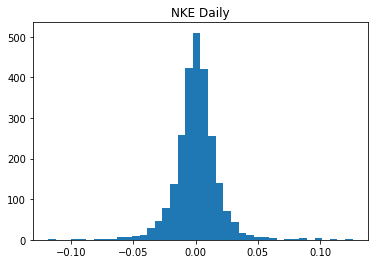

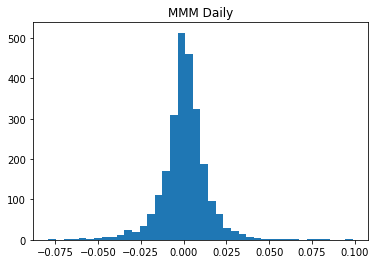

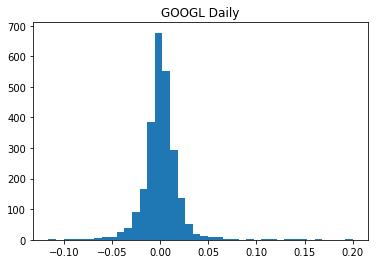

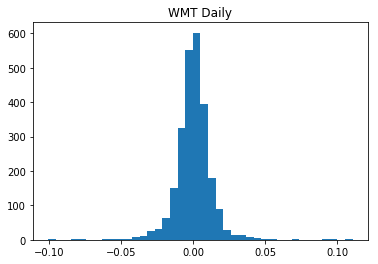

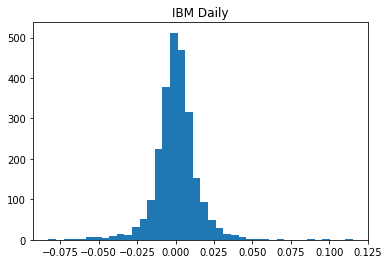

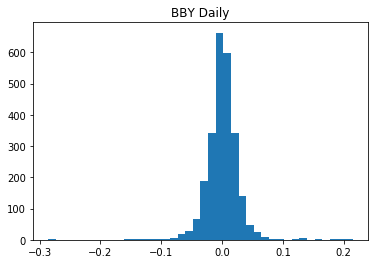

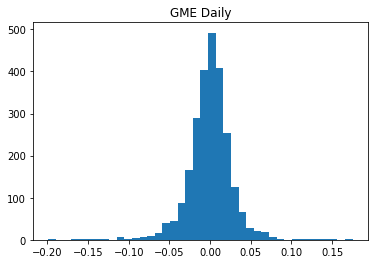

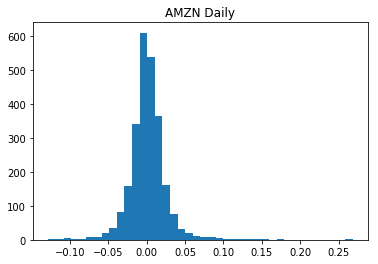

In [49]:
for comp in comps:
    plt.hist(ddf[ddf['ticker'] == comp]['ret'], bins = 40)
    plt.title(comp + ' Daily')
    plt.show()

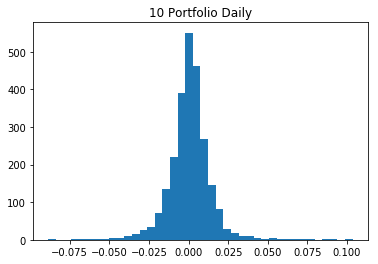

In [50]:
plt.hist(dport['ret'],bins = 40)
plt.title('10 Portfolio Daily')
plt.show()

## Graphs Monthly

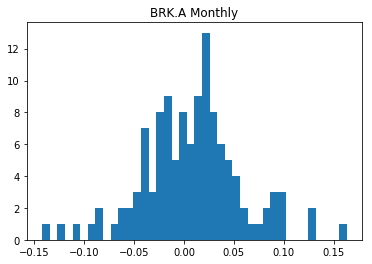

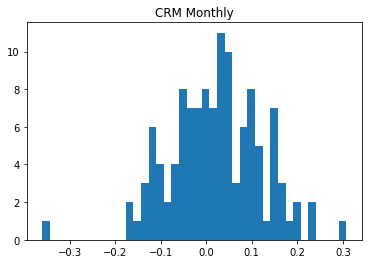

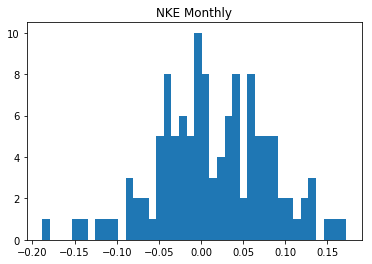

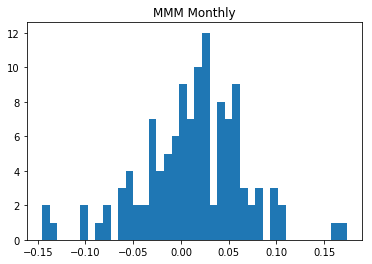

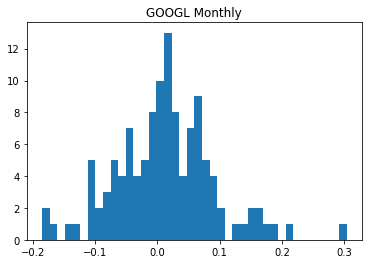

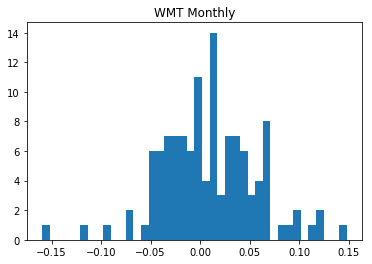

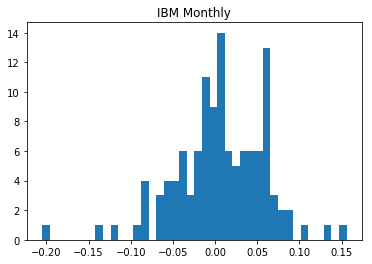

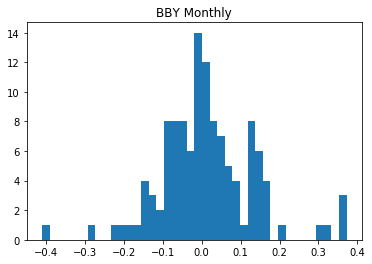

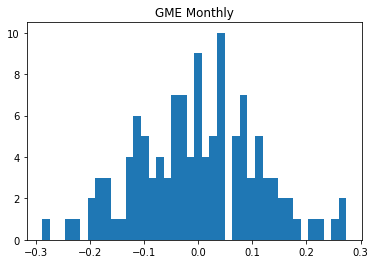

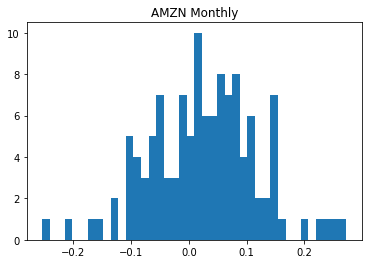

In [51]:
for comp in comps:
    plt.hist(mdf[mdf['ticker'] == comp]['ret'], bins = 40)
    plt.title(comp+ ' Monthly')
    plt.show()

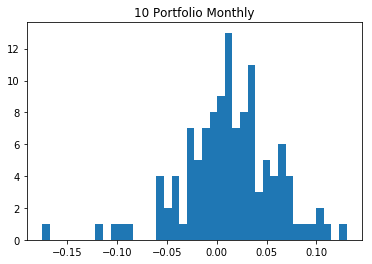

In [52]:
plt.hist(mport['ret'],bins = 40)
plt.title('10 Portfolio Monthly')
plt.show()

## Cumulative Return Graphs

In [54]:
len(ddf)/10

2516.0

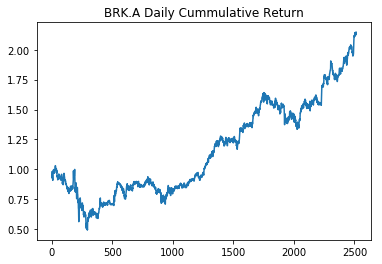

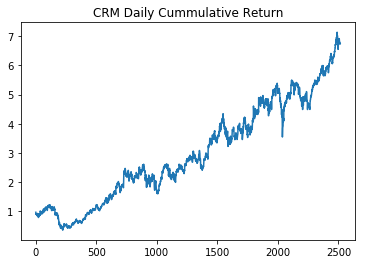

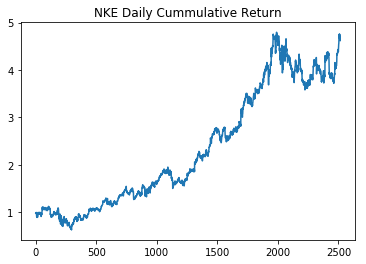

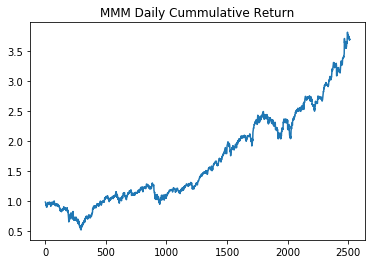

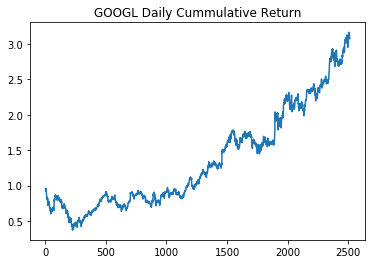

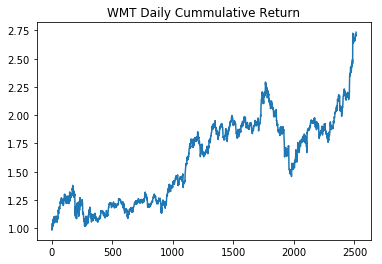

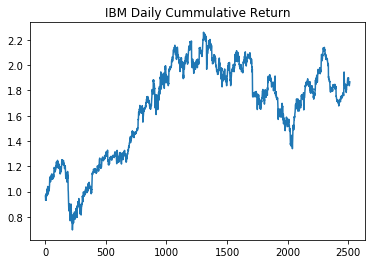

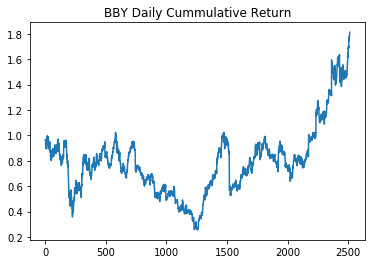

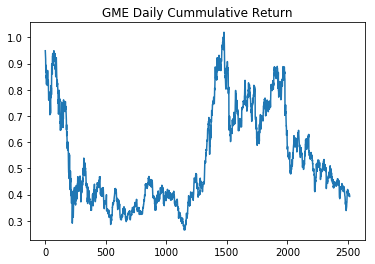

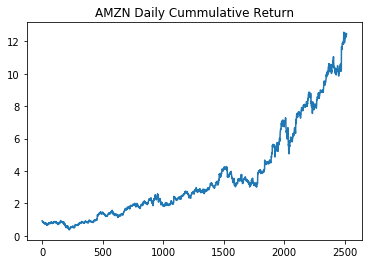

In [63]:
for comp in comps:
    ssd = ddf[ddf['ticker'] == comp]['ret']+1
    lst = []
    for i in range(1, 2516):
        p = ssd[0:i].prod()
        lst.append(p)
    plt.plot(lst)
    plt.title(comp+' Daily Cummulative Return')
    plt.show()

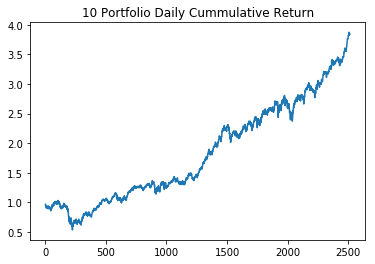

In [64]:
ssd = dport['ret']+1
lst = []
for i in range(1, 2516):
    p = ssd[0:i].prod()
    lst.append(p)
plt.plot(lst)
plt.title('10 Portfolio Daily Cummulative Return')
plt.show()

In [65]:
len(mdf)/10

120.0

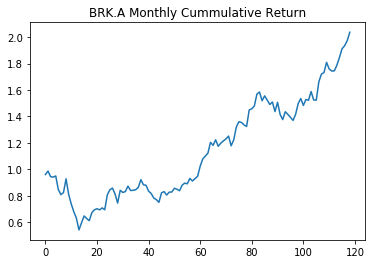

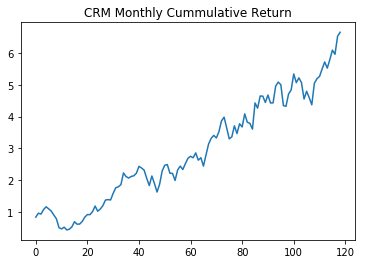

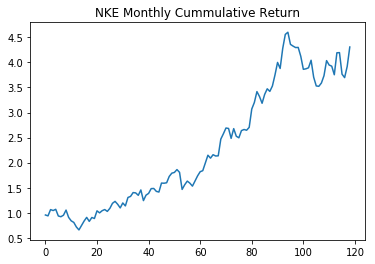

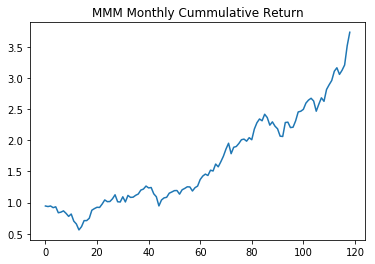

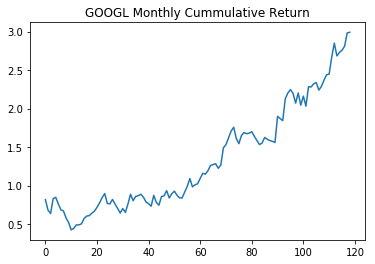

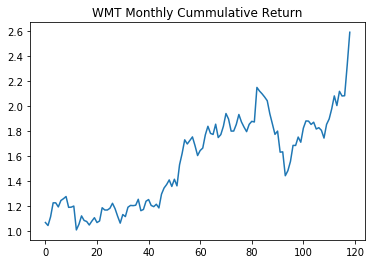

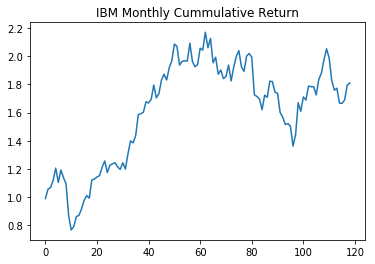

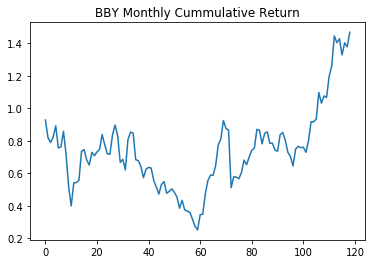

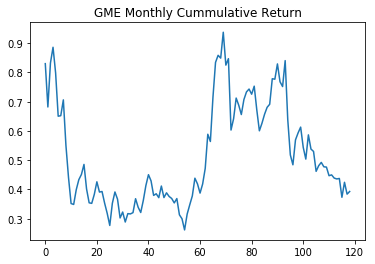

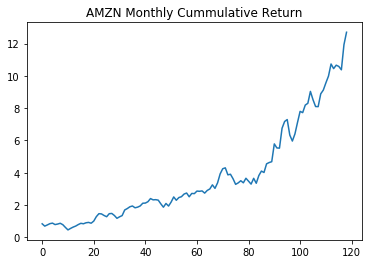

In [66]:
for comp in comps:
    ssd = mdf[mdf['ticker'] == comp]['ret']+1
    lst = []
    for i in range(1, 120):
        p = ssd[0:i].prod()
        lst.append(p)
    plt.plot(lst)
    plt.title(comp+' Monthly Cummulative Return')
    plt.show()

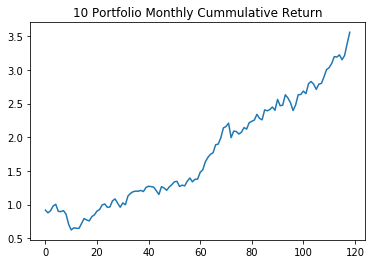

In [67]:
ssd = mport['ret']+1
lst = []
for i in range(1, 120):
    p = ssd[0:i].prod()
    lst.append(p)
plt.plot(lst)
plt.title('10 Portfolio Monthly Cummulative Return')
plt.show()